In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)

from keras.datasets import mnist
(x_train, y_train) , (x_test, y_test) = mnist.load_data()

2024-02-26 16:55:49.751437: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-26 16:55:50.267952: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 16:55:50.268054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 16:55:50.354248: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 16:55:50.518076: I tensorflow/core/platform/cpu_feature_guar

# data and parameter preparation


In [2]:
#preparation of training data
images , labels = (x_train[0:1000].reshape(1000,28*28))/225, y_train[0:1000]

one_hot_labels = np.zeros((len(labels),10))

for i,l in enumerate(labels):
    one_hot_labels[i][l] = 1

labels = one_hot_labels

In [3]:
#preparation of test data
test_images = x_test.reshape(len(x_test),28*28)/225

test_labels = np.zeros((len(y_test),10))
for i,l in enumerate(y_test):
    test_labels[i][l] = 1


In [4]:
#activation functions
def tanh(x):
    return np.tanh(x)

def tanh2deriv(x):
    return 1 - (x**2)

def softmax(x):
    temp = np.exp(x)
    return temp/np.sum(temp, axis=1, keepdims=True)

In [5]:
alpha, iterations= (2, 100)

pixels_per_image, num_labels = (28*28 ,10)
batch_size = 100

input_rows = 28
input_cols = 28

kernel_rows = 3
kernel_cols = 3
num_kernel = 16

hidden_size = ((input_rows-kernel_rows)*(input_cols-kernel_cols)*num_kernel)


In [6]:
kernels = 0.02*np.random.random((kernel_rows*kernel_cols,num_kernel))-0.01

#weights_0_1 = 0.02*np.random.random((pixels_per_image,hidden_size))-0.01
weights_1_2 = 0.2*np.random.random((hidden_size,num_labels)) - 0.1

In [7]:
def get_image_section(layer,row_from,row_to,col_from,col_to):
    section = layer[:,row_from:row_to,col_from:col_to]
    return section.reshape(-1,1,row_to-row_from, col_to-col_from)

# model training and testing


In [8]:
for j in range(iterations):
    
    correct_cnt = 0
    for i in range(int(len(images)/batch_size)):
        batch_start, batch_end = ((i * batch_size),((i+1)*batch_size))
        
        layer_0 = images[batch_start:batch_end] #Imports multiple images in batches to process # dimensions (batch_size , pixels_per_image)
        layer_0 = layer_0.reshape(layer_0.shape[0],28,28)
        layer_0.shape

        sects = list()
        for row_start in range(layer_0.shape[1]-kernel_rows):
            for col_start in range(layer_0.shape[2]-kernel_cols):
                sect = get_image_section(layer_0,row_start,row_start+kernel_rows,col_start,col_start+kernel_cols)
                sects.append(sect)

        expanded_input = np.concatenate(sects,axis=1)
        es = expanded_input.shape
        flattened_input = expanded_input.reshape(es[0]*es[1],-1)#

        kernel_output = flattened_input.dot(kernels)

        layer_1 = tanh(kernel_output.reshape(es[0],-1))
        #layer_1 = tanh( np.dot( layer_0 , weights_0_1 ) )# ((batch_size , pixels_per_image)*(pixels_per_image,hidden_size) = (batch_size,hidden_size)

        # Applying Dropout for regularization
        dropput_mask = np.random.randint(2,size= layer_1.shape )
        layer_1 *= dropput_mask*2




        layer_2 = softmax( np.dot(layer_1,weights_1_2) )# (batch_size,hidden_size) * (hidden_size,num_labels) = (batch_size,num_labels)



        # training performance measurement
        for k in range(batch_size):
            correct_cnt +=  int(np.argmax(layer_2[k:k+1]) == np.argmax(labels[batch_start+k : batch_start+k+1]))# compare the outcome with the highest probability
        


        #backpropagation calculations and weight updates 
        layer_2_delta = (labels[batch_start:batch_end] - layer_2)/ (batch_size*layer_2.shape[0]) # (batch_size,num_labels)

        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * tanh2deriv(layer_1) # (batch_size,num_labels)* (num_labels,hidden_size) = (batch_size,hidden_size)
        layer_1_delta *= dropput_mask

        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)# (hidden_size, batch_size)*(batch_size,num_labels) = (hidden_size, num_labels)
        
        
        #weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)# (pixels_per_image, batch_size)*(batch_size,hidden_size) = (pixels_per_image, hidden_size)
        l1d_reshape = layer_1_delta.reshape(kernel_output.shape)
        k_update = flattened_input.T.dot(l1d_reshape)
        kernels -= alpha * k_update
    

    # test performance measurement
    test_correct_cnt = 0
    for i in range(len(test_images)):
        layer_0 = test_images[i:i+1]
        layer_0 = layer_0.reshape(layer_0.shape[0],28,28)
        layer_0.shape

        sects = list()
        for row_start in range(layer_0.shape[1]-kernel_rows):
            for col_start in range(layer_0.shape[2]-kernel_cols):
                sect = get_image_section(layer_0,row_start,row_start+kernel_rows,col_start,col_start+kernel_cols)
                sects.append(sect)

        expanded_input = np.concatenate(sects,axis=1)
        es = expanded_input.shape
        flattened_input = expanded_input.reshape(es[0]*es[1],-1)#

        kernel_output = flattened_input.dot(kernels)

        layer_1 = tanh(kernel_output.reshape(es[0],-1))
        layer_2 = np.dot(layer_1,weights_1_2)

        test_correct_cnt +=  int(np.argmax(layer_2) == np.argmax(test_labels[i:i+1])) # compare the outcome with the highest probability

    if (j % 10 == 0):
        print("\n"+ "I:" + str(j) + " Test-Acc:"+str(test_correct_cnt/float(len(test_images)))+" Train-Acc:" + str(correct_cnt/float(len(images))))




I:0 Test-Acc:0.076 Train-Acc:0.09

I:10 Test-Acc:0.0254 Train-Acc:0.038

I:20 Test-Acc:0.7698 Train-Acc:0.653

I:30 Test-Acc:0.788 Train-Acc:0.678

I:40 Test-Acc:0.8301 Train-Acc:0.792

I:50 Test-Acc:0.8525 Train-Acc:0.81

I:60 Test-Acc:0.8609 Train-Acc:0.823

I:70 Test-Acc:0.8672 Train-Acc:0.866

I:80 Test-Acc:0.8661 Train-Acc:0.871

I:90 Test-Acc:0.8671 Train-Acc:0.883


TypeError: only length-1 arrays can be converted to Python scalars

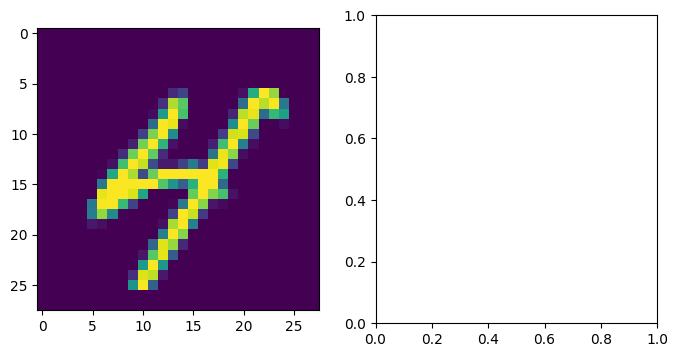

In [13]:
a = np.random.randint(len(test_images))

layer_0 = test_images[a]
layer_0 = layer_0.reshape(28,28)
layer_0.shape

sects = list()
for row_start in range(layer_0.shape[0]-kernel_rows):
    for col_start in range(layer_0.shape[1]-kernel_cols):
        sect = get_image_section(layer_0,row_start,row_start+kernel_rows,col_start,col_start+kernel_cols)
        sects.append(sect)

expanded_input = np.concatenate(sects,axis=1)
es = expanded_input.shape
flattened_input = expanded_input.reshape(es[0]*es[1],-1)#

kernel_output = flattened_input.dot(kernels)

layer_1 = tanh(kernel_output.reshape(es[0],-1))
layer_2 = np.dot(layer_1,weights_1_2)

rgb = 'green' if np.argmax(layer_2) == np.argmax(test_labels[a]) else 'red'


fig, axs = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(8)

axs[0].imshow(layer_0.reshape(28,28))

axs[1].bar(range(len(layer_2)), layer_2)
axs[1].bar(range(len(layer_2)), test_labels[a],color = rgb)


print("Prediction",[round(a,1) for a in layer_2])
print("Label",[round(a,1) for a in test_labels[a]])